# NLP & Binary Classification: IMDB sentiment analysisdata
https://keras.io/datasets/


** Dataset Information: **

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative)

** Attribute Information: (1 features and 1 class) **

- review: preprocessed, a sequence of word indexes
- sentiment: positive/negative

** Objective of this project **

predict whether a review is thumbs-up or thumbs-down

# Data

In [1]:
import numpy as np
from keras.datasets import imdb
from matplotlib import pyplot as plt
%matplotlib inline

# load Data
(X_train, y_train), (X_test, y_test) = imdb.load_data()
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

Using TensorFlow backend.


In [2]:
# feature (review)
print(X.shape,y.shape)
#X[0]

(50000,) (50000,)


In [3]:
# class (setiment)
print(np.unique(y_train,return_counts=True))

(array([0, 1], dtype=int64), array([12500, 12500], dtype=int64))


In [4]:
# total unique words
print(len(np.unique(np.hstack(X))))

88585


Review length: Mean 234.8 words (172.9)


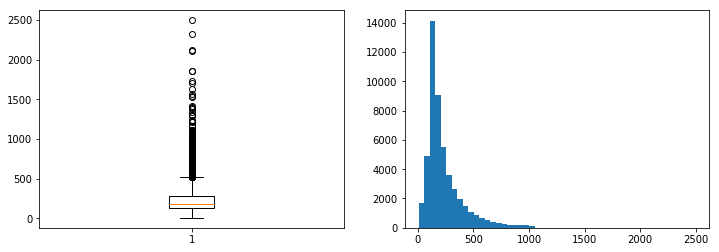

In [5]:
# review length
result = [len(x) for x in X]
print("Review length: Mean %.1f words (%.1f)" % (np.mean(result), np.std(result)))

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.boxplot(result)
plt.subplot(1, 2, 2)
plt.hist(result,bins=50)
plt.show()

# Data Preprocessing

In [35]:
# fix random seed for reproducibility
seed = 113
np.random.seed(seed)

In [51]:
# load the top 5000 words (vocabulary)
vocab_size = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size,
                                                      seed=seed)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
#X_train[0]

(25000,) (25000,) (25000,) (25000,)


In [52]:
# truncate reviews at 500 words and zero padding for shorter one
from keras.preprocessing.sequence import pad_sequences
length = 500
X_train = pad_sequences(X_train, maxlen=length, padding='post')
X_test = pad_sequences(X_test, maxlen=length, padding='post')
print(X_train.shape,X_test.shape)
#X_train[0]

(25000, 500) (25000, 500)


# 3 channel CNN model

### Model Train

In [39]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input,Dense,Dropout,Embedding,Flatten
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers.merge import concatenate

# channel 1
inputs1 = Input(shape=(length,))
embedding1 = Embedding(vocab_size, 100)(inputs1)
conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)
# channel 2
inputs2 = Input(shape=(length,))
embedding2 = Embedding(vocab_size, 100)(inputs2)
conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)
# channel 3
inputs3 = Input(shape=(length,))
embedding3 = Embedding(vocab_size, 100)(inputs3)
conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)
# merge
merged = concatenate([flat1, flat2, flat3])
# interpretation
dense1 = Dense(10, activation='relu')(merged)
outputs = Dense(1, activation='sigmoid')(dense1)
model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
# compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 500, 100)     500000      input_7[0][0]                    
__________________________________________________________________________________________________
embedding_

In [40]:
# train the model
model.fit([X_train,X_train,X_train], y_train, 
          validation_data=([X_test,X_test,X_test], y_test), 
          epochs=2, batch_size=128, verbose=2)

# save the model
model.save('model.h5')
# load the model
from pickle import load
model = load_model('model.h5')

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 - 408s - loss: 0.4475 - acc: 0.7649 - val_loss: 0.2959 - val_acc: 0.8835
Epoch 2/2
 - 428s - loss: 0.2175 - acc: 0.9164 - val_loss: 0.2772 - val_acc: 0.8857


### Model Evaluation with Test set

In [49]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

# predict class with test set
y_pred_test =  model.predict([X_test,X_test,X_test], batch_size=128, verbose=0)
print('Accuracy: {:0.1f}%'.format(accuracy_score(y_test,y_pred_test>0.5)*100))

Accuracy: 88.6%




             precision    recall  f1-score   support

          0       0.86      0.91      0.89     12500
          1       0.91      0.86      0.88     12500

avg / total       0.89      0.89      0.89     25000



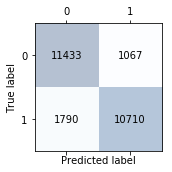

In [50]:
#classification report
print('\n')
print(classification_report(y_test, y_pred_test>0.5))

#confusion matrix
confmat = confusion_matrix(y_test, y_pred_test>0.5)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()